In [1]:
from catboost import Pool, CatBoostRegressor
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, RidgeCV, LassoCV, ElasticNetCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score, f1_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline

In [2]:
def parse_csv(path, col_name, start_index=0):
    df = pd.read_csv(path, decimal=',')
    list_of_df = []
    for i in range(len(df)):
        new_df = df.iloc[i,:].to_frame(name=col_name).reset_index()
        if col_name == 'flammability':
            new_df = df.iloc[i,:].to_frame(name="flammability").reset_index()
            new_df['region'] = new_df.iloc[1,1]
            new_df['OSM_ID'] = new_df.iloc[0,1]
            new_df = new_df.iloc[3:,:]
            list_of_df.append(new_df)
        else:
            new_df['OSM_ID'] = new_df.iloc[0,1]
            new_df = new_df.iloc[1:,:]
            list_of_df.append(new_df)
    
    df = pd.concat(list_of_df).reset_index()
    df = df.rename(columns={"index": "year"})
    df = df.drop(['level_0'], axis=1)
    return df

list_of_df = [parse_csv('data/flam_dynamics.csv', 'flammability', 1),
              parse_csv('data/NDVI_dynamics.csv', 'NDVI'),
              parse_csv('data/precip_dynamics.csv', 'precipitation'),
              parse_csv('data/stock_dynamics.csv','livestock'),
              parse_csv('data/t_max_dynamics.csv','t_max')]
list_of_df[0]

,year,flammability,region,OSM_ID
0,2001,28.62,Ахтубинский район,-1850408
1,2002,15.94,Ахтубинский район,-1850408
2,2003,0.66,Ахтубинский район,-1850408
3,2004,2.52,Ахтубинский район,-1850408
4,2005,11.46,Ахтубинский район,-1850408
...,...,...,...,...
1155,2016,0.0,Уральск Г.А.,-3767383
1156,2017,1.25,Уральск Г.А.,-3767383
1157,2018,4.8,Уральск Г.А.,-3767383
1158,2019,0.0,Уральск Г.А.,-3767383


In [3]:
df_subjects = pd.read_csv('data/flam_dynamics.csv', decimal=',')
df_subjects['Region'].unique()

array(['AST', 'ATY', 'KL', 'SAR', 'VGG', 'ZKO'], dtype=object)

In [4]:
df_subjects.head()

,OSM_ID,NAME,Region,2001,2002,2003,2004,2005,2006,2007,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,-1850408,Ахтубинский район,AST,28.62,15.94,0.66,2.52,11.46,16.28,3.77,...,2.11,4.00,0.0,16.59,1.42,2.39,20.90,0.74,2.68,4.33
1,-1863175,Володарский район,AST,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,-1853865,городской округ Астрахань,AST,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,-1853856,Енотаевский район,AST,10.63,7.04,2.07,3.16,2.48,13.61,1.58,...,2.95,1.01,0.0,1.54,0.00,0.14,0.18,0.00,0.12,0.00
4,-1957534,Икрянинский район,AST,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00


![title](img/UFO1_pol.jpg)

![title](img/kaz_pol.png)

In [5]:
df_region = pd.read_csv('data/Municipals.csv', encoding="windows-1251", delimiter=';', decimal=',')
df_region = df_region.drop(['Region','NAME', 'Area_ha'], axis=1)

In [6]:
import functools as ft
df = ft.reduce(lambda left, right: pd.merge(left, right, on=['OSM_ID','year']), list_of_df)

In [7]:
df = df.merge(df_region, on=['OSM_ID'])
df.head()

,year,flammability,region,OSM_ID,NDVI,precipitation,livestock,t_max,N,E
0,2001,28.62,Ахтубинский район,-1850408,3443.553826,305.300003,NaN,22.864286,48.288975,46.400784
1,2002,15.94,Ахтубинский район,-1850408,3283.658314,327.975006,NaN,22.464286,48.288975,46.400784
2,2003,0.66,Ахтубинский район,-1850408,2986.687553,318.075005,NaN,20.989285,48.288975,46.400784
3,2004,2.52,Ахтубинский район,-1850408,3269.350491,319.725006,NaN,22.935715,48.288975,46.400784
4,2005,11.46,Ахтубинский район,-1850408,3305.540993,312.275009,NaN,22.800001,48.288975,46.400784


![title](img/ndvi.png)
t_max - динамика максимальных температур за год  
precipitation - динамика кол-ва осадков  
livestock - динамика поголовья скота  
NDVI - динамика нормализованного относительного индекса растительности

In [8]:
df = df.fillna(-9999)
df['flammability'] = df['flammability'] + 0.001
df['flammability'] = np.log1p(df['flammability'])

In [9]:
df['previous_precipitation'] = df['precipitation'].shift(+1)
df.loc[df['year'] == '2001', 'previous_precipitation'] = np.nan
df['previous_precipitation'] = df.groupby(['region']).previous_precipitation.transform(lambda x: x.fillna(x.mean()))

df['previous_NDVI'] = df['NDVI'].shift(+1)
df.loc[df['year'] == '2001', 'previous_NDVI'] = np.nan
df['previous_NDVI'] = df.groupby(['region']).previous_NDVI.transform(lambda x: x.fillna(x.mean()))

Почему мы используем смещенные показали? Т.к. все показатели считаются на конец года, логично использовать смещенные данные, из практических целей это означает, что нам интересны условия предыдущего.

In [10]:
df = df.drop(['OSM_ID', 'year', 'region','precipitation', 'NDVI'], axis=1)
df.corr()

,flammability,livestock,t_max,N,E,previous_precipitation,previous_NDVI
flammability,1.000000,-0.071300,-0.160516,0.273221,0.231178,0.164843,-0.062819
livestock,-0.071300,1.000000,0.257455,0.048927,0.254161,-0.231002,-0.155804
t_max,-0.160516,0.257455,1.000000,-0.723279,0.176638,-0.675664,-0.330992
N,0.273221,0.048927,-0.723279,1.000000,0.180268,0.539406,0.147333
E,0.231178,0.254161,0.176638,0.180268,1.000000,-0.431731,-0.356354
previous_precipitation,0.164843,-0.231002,-0.675664,0.539406,-0.431731,1.000000,0.519401
previous_NDVI,-0.062819,-0.155804,-0.330992,0.147333,-0.356354,0.519401,1.000000


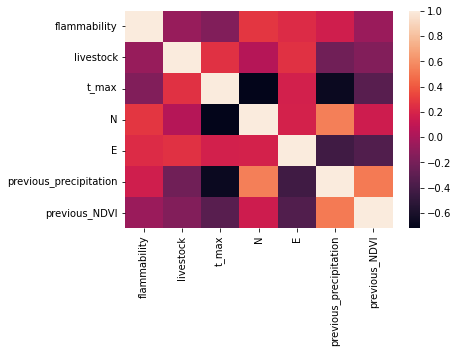

In [11]:
uniform_data = np.random.rand(20, 15)
ax = sns.heatmap(df.corr())

In [12]:
col_names = ['livestock', 't_max', 'previous_precipitation','N','E', 'previous_NDVI']
X = df[col_names]
cv = 10
scalers = (RobustScaler(), StandardScaler(), MinMaxScaler())

regressors = (
    RidgeCV(cv=cv, alphas=[0.0001, 0.001,0.01, 0.1, 1]), 
    LassoCV(cv=cv, alphas=[0.0001, 0.001,0.01, 0.1, 1], n_alphas=[100, 200, 300, 400]), 
    ElasticNetCV(cv=cv, alphas=[0.0001, 0.001,0.01, 0.1, 1, 10], n_alphas=[100, 200, 300, 400])
)

for scaler in scalers:
    for regressor in regressors:
        ct = ColumnTransformer([('scaler', scaler, ['livestock', 't_max', 
                                                    'previous_precipitation', 'previous_NDVI'])], remainder='passthrough')
        X_scaled = ct.fit_transform(X)
        X_train, X_test, y_train, y_test = train_test_split(X_scaled, df['flammability'], test_size=0.20, random_state=42)               
        
        regressor.fit(X_train, y_train)
        y_pred = regressor.predict(X_test)
        
        print('R2: ' + str(regressor.score(X_test, y_test)))
        print('RMSE: ' + str(mean_squared_error(y_test, y_pred, squared=False)))
        print('MAE: ' + str(mean_absolute_error(y_test, y_pred)))
        print('Scaler: ' + scaler.__class__.__name__)
        print('Regressor\'s type:' + regressor.__class__.__name__)
        print('Best Alpha: ' + str(regressor.alpha_))
        print()
#         for col, coef in zip(df.columns, regressor.coef_):
#             print(col, coef)
        print('==' * 20)

R2: 0.11113801881570018
RMSE: 0.9285178718788393
MAE: 0.7662739680456742
Scaler: RobustScaler
Regressor's type:RidgeCV
Best Alpha: 1.0

R2: 0.11093433025536148
RMSE: 0.9286242537687213
MAE: 0.7662845501131181
Scaler: RobustScaler
Regressor's type:LassoCV
Best Alpha: 0.0001

R2: 0.111320065699679
RMSE: 0.9284227826272643
MAE: 0.7663455786284029
Scaler: RobustScaler
Regressor's type:ElasticNetCV
Best Alpha: 0.001

R2: 0.11098748078966214
RMSE: 0.9285964956319362
MAE: 0.7662900764830082
Scaler: StandardScaler
Regressor's type:RidgeCV
Best Alpha: 1.0

R2: 0.11090417408407383
RMSE: 0.9286400026135767
MAE: 0.7662929065121764
Scaler: StandardScaler
Regressor's type:LassoCV
Best Alpha: 0.0001

R2: 0.11110137357732641
RMSE: 0.9285370117502594
MAE: 0.7663953523352469
Scaler: StandardScaler
Regressor's type:ElasticNetCV
Best Alpha: 0.001

R2: 0.11363103152030529
RMSE: 0.9272148393051961
MAE: 0.7666255187269011
Scaler: MinMaxScaler
Regressor's type:RidgeCV
Best Alpha: 1.0

R2: 0.11106588710910359


In [13]:
#Test Default CatBoost
print("Testing default Catboost")

scalers = (RobustScaler(), StandardScaler(), MinMaxScaler())
for scaler in scalers:
    
    ct = ColumnTransformer([('scaler', scaler, ['livestock', 't_max', 
                                                'previous_precipitation', 'previous_NDVI'])], remainder='passthrough')
    
    X_scaled = ct.fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, 
                                                        df['flammability'], 
                                                        test_size=0.20, random_state=42)  
    model = CatBoostRegressor(logging_level='Silent')
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    rmse = (np.sqrt(mean_squared_error(y_test, pred)))
    r2 = r2_score(y_test, pred)
    
    print('R2: ' + str(r2))
    print('RMSE: ' + str(mean_squared_error(y_test, y_pred, squared=False)))
    print('MAE: ' + str(mean_absolute_error(y_test, y_pred)))
    print('Scaler: ' + scaler.__class__.__name__)
    #print(model.get_all_params())
    print('==' * 20)

Testing default Catboost
R2: 0.5578050457850738
RMSE: 0.9285204611928828
MAE: 0.7663138111369993
Scaler: RobustScaler
R2: 0.5578006997362444
RMSE: 0.9285204611928828
MAE: 0.7663138111369993
Scaler: StandardScaler
R2: 0.5605416960472617
RMSE: 0.9285204611928828
MAE: 0.7663138111369993
Scaler: MinMaxScaler


In [14]:
scaler = MinMaxScaler()
ct = ColumnTransformer([('scaler', scaler, ['livestock', 't_max', 
                                                'previous_precipitation', 'previous_NDVI'])], remainder='passthrough')
X_scaled = ct.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, 
                                                    df['flammability'], 
                                                    test_size=0.20, random_state=42)
model = CatBoostRegressor(logging_level='Silent')

grid = { 
        'learning_rate': [0.01, 0.03, 0.04, 0.1, 0.5],
        'depth': [4, 6, 8],
        'l2_leaf_reg': [1, 3, 5, 7],
        'iterations': [250, 500, 1000]
       }

grid_search = model.grid_search(grid, X=X_train, y=y_train, plot=True, verbose=False)
#grid.fit(X_train, y_train)

pred = model.predict(X_test)
rmse = (np.sqrt(mean_squared_error(y_test, pred)))

r2 = r2_score(y_test, pred)
print('R2: ' + str(r2))
print('RMSE: ' + str(mean_squared_error(y_test, y_pred, squared=False)))
print('MAE: ' + str(mean_absolute_error(y_test, y_pred)))
print('Scaler: ' + scaler.__class__.__name__)
print('Best params: ' + str(grid_search['params']))
print('==' * 20)
for x, y in zip(df.drop(['flammability'], axis=1), model.get_feature_importance()):
    print(x, y)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

R2: 0.5732134618919175
RMSE: 0.9285204611928828
MAE: 0.7663138111369993
Scaler: MinMaxScaler
Best params: {'depth': 8, 'l2_leaf_reg': 1, 'iterations': 1000, 'learning_rate': 0.03}
livestock 18.23514022680456
t_max 12.194223720439567
N 13.786393379148267
E 13.413822296483064
previous_precipitation 19.623732171265374
previous_NDVI 22.74668820585917


In [15]:
data_test = pd.merge(pd.DataFrame(X_test), y_test, left_index=True, right_index=True)
data_pred = pd.merge(pd.DataFrame(X_test), pd.Series(pred, y_test.index, name='predicted_flammability'), left_index=True, right_index=True)
data_test['flammability']

3      1.258745
10     1.134944
23     0.001000
30     0.001000
31     0.001000
39     0.001000
43     0.001000
44     0.001000
49     0.001000
51     0.001000
54     0.001000
56     0.001000
59     0.001000
70     1.373969
76     0.166362
78     0.114221
83     0.001000
86     0.001000
88     0.001000
96     0.001000
101    0.001000
107    0.001000
109    0.001000
113    0.001000
128    3.151496
136    2.602764
138    2.207285
139    2.915660
140    0.077887
141    2.662425
156    0.728032
158    0.001000
170    1.568824
174    0.406132
178    0.231905
184    0.001000
192    0.001000
198    0.001000
199    0.001000
208    1.088899
209    0.308220
210    2.735082
218    0.379121
220    1.693963
231    0.270790
Name: flammability, dtype: float64

In [19]:
for i in df_region['N'].unique():
    if len(data_test[data_test[4]==i]) == 0:
        continue
    rmse = str(mean_squared_error(data_test[data_test[4]==i]['flammability'], 
                                  data_pred[data_pred[4]==i]['predicted_flammability'], 
                                  squared=False))
    print(rmse)

0.023564562143524717
0.029941751787542062
0.4720104541908867
1.1071079480481592
0.055289362955374635
0.12495634996541878
0.703121445081885
0.44487588341638723
0.23020313644446974
1.550079267435865
1.1180308966342878
0.1392346421810666
0.15485477358014807
1.4026327361465347
0.04916444186965434
0.9907550340661097
0.9161553628323981
0.06629257366702407
1.2530770728235425
0.14168215924067296
0.07375068376048984
0.031092284214978824
0.22153880424119193
0.7478505990192051
0.21251708387728477
1.4084811972508047
0.11464794577542763
0.02560473414212998
0.015542657288922498
0.3726622558167876
0.058887644473650205
0.12901073725451517
1.204555177119245
0.6601774642247694


In [17]:
# X_train, X_test, y_train, y_test = train_test_split(X_scaled, 
#                                                         df['flammability'], 
#                                                         test_size=0.20 random_state=42)

# print(type(X_test))
# param_grid = {
#     'C': [1, 5, 100, 200, 1000],
#     'epsilon': [0.01, 0.1, 0.05, 0.0003, 1, 0.2, 5, 10],
#     'gamma': [0.001, 0.1, 1, 5, 10, 100]
# }
# grid_search = GridSearchCV(estimator = SVR(), param_grid = param_grid, cv = 10, n_jobs = -1, verbose = 0)
# regr = make_pipeline(RobustScaler(), grid_search)


# regr.fit(X_train, y_train)
# print(regr.score(X_test, y_test))
# print(regr[1].best_params_)

In [18]:
# X_train, X_test, y_train, y_test = train_test_split(X_scaled, 
#                                                         df['flammability'], 
#                                                         test_size=0.20, random_state=42)
# knn = KNeighborsRegressor()
# k_range = list(range(1, 50))
# param_grid = dict(n_neighbors=k_range)
  
# # defining parameter range
# grid = GridSearchCV(knn, param_grid, cv=10, verbose=1)

# # fitting the model for grid search
# grid.fit(X_train, y_train)
# print(grid.best_estimator_)
# grid.score(X_test, y_test)

Что можно сделать ещё?

1. Поискать ещё признаки.
1. Выяснить для каких районов/регионов мы хорошо предсказываем горимость.
2. Добавить карт.